In [1]:
import sys
sys.path.append("../")

In [2]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import open3d
import cv2
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from utils.fisheye.FishEyeCalibrated import FishEyeCameraCalibrated

In [4]:
img_dataset = "C:/workspace/code/_ego_pose/GlobalEgoMocap-main/TestDataset_EgocentricGlobalPose"

In [5]:
img_path = f"{img_dataset}/jian1/imgs/img_000000.jpg"

calibration_path = '../utils/fisheye/fisheye.calibration_05_08.json'

In [6]:
camera = FishEyeCameraCalibrated(calibration_file_path=calibration_path)

img = cv2.imread(img_path)

In [7]:
# pt2d_img = img.reshape(-1, 3)

y = np.arange(img.shape[0])
x = np.arange(img.shape[1])
xx, yy = np.meshgrid(x, y)

In [8]:
img_pt2d = np.stack([xx, yy]).T
zz = np.ones_like(xx)

# depth = np.stack([xx, yy, zz]).transpose(1,2,0)
depth = zz

In [9]:
img_pt2d.shape, depth.shape

((1280, 1024, 2), (1024, 1280))

In [10]:
# undistort_img = camera.undistort(img)
# undistort_img = camera.undistort(np.stack([xx, yy]))
# undistort_img = camera.undistort(pt2d_xy)

In [11]:
pt3d = camera.camera2world(img_pt2d.reshape(-1, 2), depth.reshape(-1))

In [12]:
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(pt3d)

open3d.visualization.draw_geometries([pcd])

In [13]:
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(pt3d)
pcd.colors = open3d.utility.Vector3dVector(img[:, :, ::-1].reshape(-1, 3)/255)

open3d.visualization.draw_geometries([pcd])

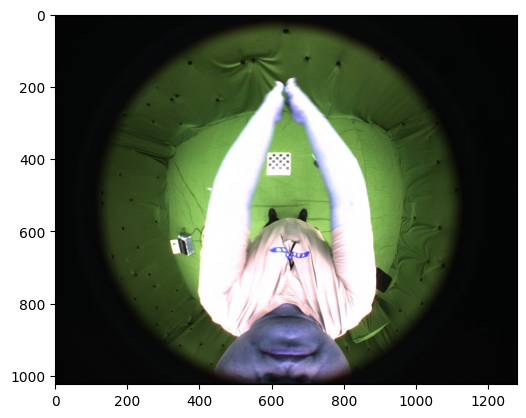

In [14]:
plt.imshow(img)

In [22]:
def create_perspecive_undistortion_LUT(img, camera, sf=4.0):
    H, W = img.shape[:2]
    z  = -W / sf
    EPS = 1e-5
    x = np.arange(W) - W/2 + EPS # to avoid zero norm
    y = np.arange(H) - H/2 + EPS 
    # x = np.arange(W) + EPS # to avoid zero norm
    # y = np.arange(H) + EPS 
    x_grid, y_grid = np.meshgrid(x, y, sparse=False, indexing='xy')
    # point3D = np.stack([x_grid, y_grid, np.full_like(x_grid, z)]).reshape(3, -1).T
    # point2D = camera.world2camera(point3D)
    # mapx, mapy = point2D[:,0], point2D[:,1]

    point3D = np.stack([x_grid, y_grid, np.full_like(x_grid, z)]).reshape(3, -1)
    point2D = camera.world2cam_valid(point3D)
    mapx, mapy = point2D[0], point2D[1]
    print(point2D.shape)
    
    mapx = mapx.reshape(H, W).astype(np.float32)
    mapy = mapy.reshape(H, W).astype(np.float32)
    return mapx, mapy

In [23]:
mapx, mapy = create_perspecive_undistortion_LUT(img, camera)

(2, 1310720)


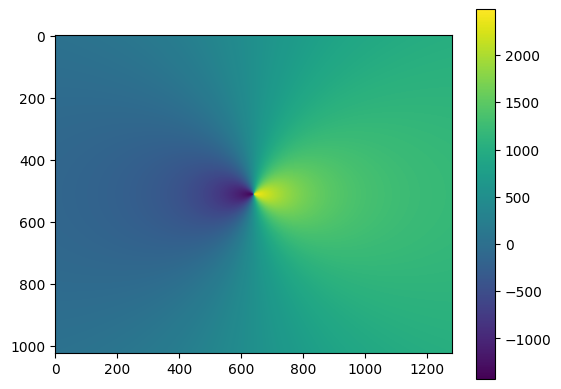

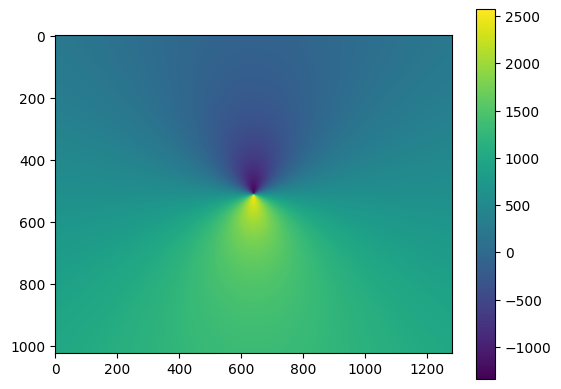

In [24]:
plt.imshow(mapx)
plt.colorbar()
plt.show()

plt.imshow(mapy)
plt.colorbar()
plt.show()

In [ ]:
undistort = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

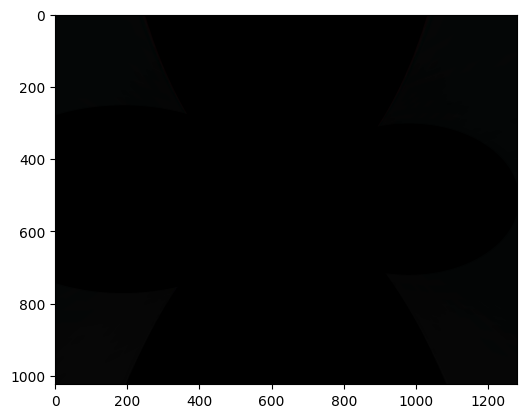

In [ ]:
plt.imshow(undistort)